In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# K-NN

In [2]:
df = pd.read_csv('cardio_train.csv', sep=';')
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69296,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69297,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69298,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69299,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


## Remoção de outliers

In [3]:
df_outliers = df[(df.ap_hi <= df.ap_lo) | (df.ap_hi < 120) | (df.ap_hi > 300) | (df.ap_lo < 0) | (df.ap_lo > 300)]
df = df.drop(df_outliers.index, axis=0)
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0
7,997,22547,1,161,93.0,140,90,2,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69296,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69297,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69298,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69299,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


## Escolha dos atributos

In [4]:
df = df[['age', 'weight', 'ap_hi', 'cardio']]

In [5]:
df = df.astype({'age': 'int32'})
df['age'] = df['age'] / 365
df = df.astype({'age': 'int32'})
df

,age,weight,ap_hi,cardio
0,61,69.0,130,0
2,60,70.0,120,0
3,39,85.0,120,0
4,64,62.0,120,0
7,61,93.0,140,1
...,...,...,...,...
69296,52,76.0,120,0
69297,61,126.0,140,1
69298,52,105.0,180,1
69299,61,72.0,135,1


## Grupos

In [6]:
df['color'] = df.cardio.map(lambda c: 'red' if c == 1 else 'blue')
df

,age,weight,ap_hi,cardio,color
0,61,69.0,130,0,blue
2,60,70.0,120,0,blue
3,39,85.0,120,0,blue
4,64,62.0,120,0,blue
7,61,93.0,140,1,red
...,...,...,...,...,...
69296,52,76.0,120,0,blue
69297,61,126.0,140,1,red
69298,52,105.0,180,1,red
69299,61,72.0,135,1,red


In [7]:
df['id'] = range(0, len(df.index))
df = df.set_index('id')
df

,age,weight,ap_hi,cardio,color
id,,,,,
0,61,69.0,130,0,blue
1,60,70.0,120,0,blue
2,39,85.0,120,0,blue
3,64,62.0,120,0,blue
4,61,93.0,140,1,red
...,...,...,...,...,...
55407,52,76.0,120,0,blue
55408,61,126.0,140,1,red
55409,52,105.0,180,1,red


/tmp/ipykernel_17865/3951413702.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


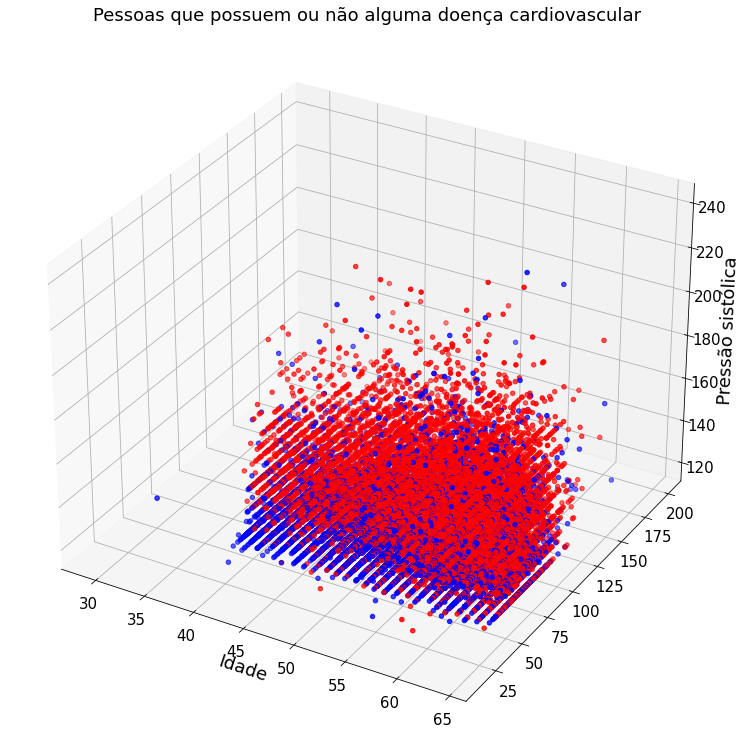

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
ax = Axes3D(fig)
ax.set_title('Pessoas que possuem ou não alguma doença cardiovascular', fontsize=18)
ax.set_xlabel('Idade', fontsize=18)
ax.set_zlabel('Peso', fontsize=18)
ax.set_zlabel('Pressão sistólica', fontsize=18)

ax.scatter(xs=df.age, ys=df.weight, zs=df.ap_hi, c=df['color'])

## Training and Testing Data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def training_test(df, k, p=2, weights='uniform'):
    X = df[['age', 'weight', 'ap_hi']]
    Y = df.cardio

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    classifier = KNeighborsClassifier(n_neighbors = k, p=p, weights=weights)
    classifier.fit(X_train, Y_train)
    result = classifier.predict(X_test)
    return accuracy_score(Y_test, result)

## Como a acurácia se comporta com relação ao tamanho da base?

5542
11083
16624
22165
27706
33248
38789
44330
49871
55412


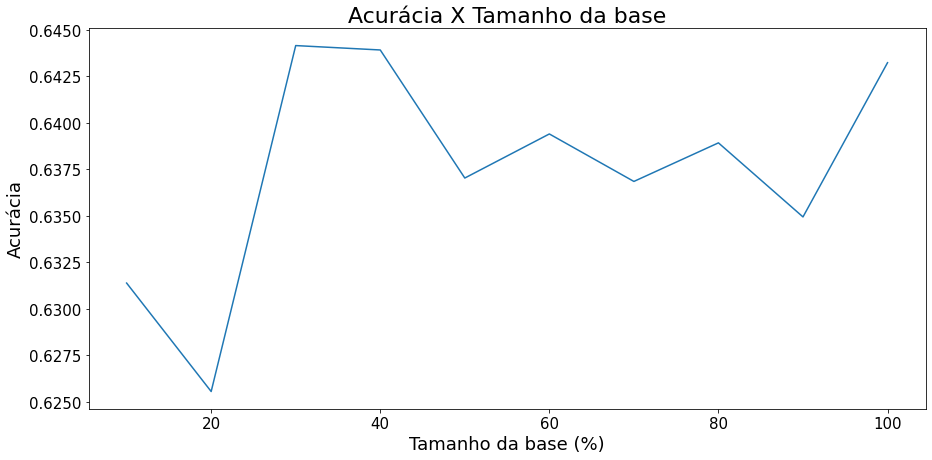

In [10]:
accuracy_tam_base = {'tam': [], 'accuracy': []}

for n in range(10, 101, 10):
    df_aux = df[df.index < ((len(df.index) * n) / 100)]
    print(len(df_aux.index))
    accuracy = training_test(df=df_aux, k=3, weights='distance', p=1)
    accuracy_tam_base['tam'].append(n)
    accuracy_tam_base['accuracy'].append(accuracy)


plt.figure(figsize=(15, 7))
plt.title('Acurácia X Tamanho da base', fontsize=22)
plt.xlabel('Tamanho da base (%)', fontsize=18)
plt.ylabel('Acurácia', fontsize=18)
plt.plot(accuracy_tam_base['tam'], accuracy_tam_base['accuracy'])
plt.show()

## Quanto ao número de vizinhos?

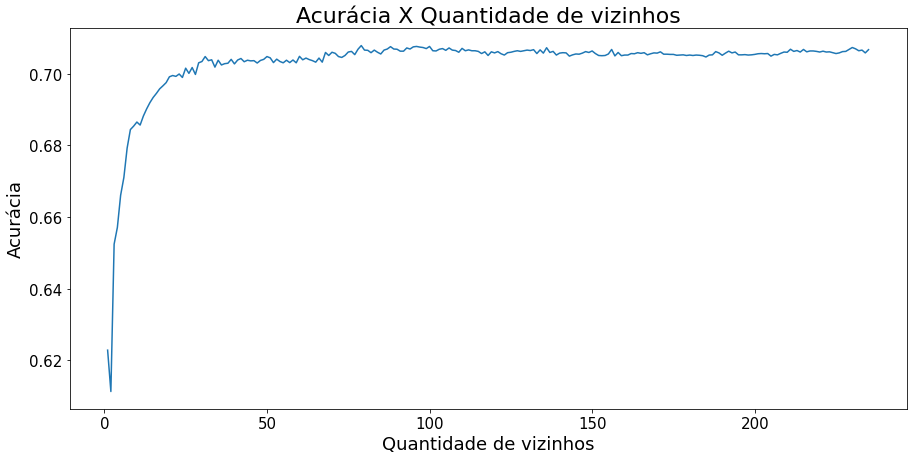

In [11]:
import math

accuracy_k_base = {'k':[], 'accuracy':[]}
tamanho_base = len(df.index)

for k in range(1, round(math.sqrt(tamanho_base)) + 1):
    accuracy = training_test(df=df, k=k)
    accuracy_k_base['k'].append(k)
    accuracy_k_base['accuracy'].append(accuracy)
    
plt.figure(figsize=(15, 7))
plt.title('Acurácia X Quantidade de vizinhos', fontsize=22)
plt.xlabel('Quantidade de vizinhos', fontsize=18)
plt.ylabel('Acurácia', fontsize=18)
plt.plot(accuracy_k_base['k'], accuracy_k_base['accuracy'])

In [12]:
def melhor_k(accuracy_k_base):
    index_maior = 0
    valor_accuracy = accuracy_k_base['accuracy'][0]
    for i in range(1, len(accuracy_k_base['k'])):
        if(valor_accuracy < accuracy_k_base['accuracy'][i]):
            valor_accuracy = accuracy_k_base['accuracy'][i]
            index_maior = i
    return index_maior       

#Pegado o melhor valor para K
k = melhor_k(accuracy_k_base)
if (k % 2) == 0 : k += 1
k

79

## Quanto a medida de distância utilizada

In [13]:
accuracy = training_test(df=df, k=k, p=1)
print(accuracy)
accuracy = training_test(df=df, k=k, p=2)
print(accuracy)

0.7079523580365736
0.7078922040423484


## Atribuição de pesos para vizinhos

In [14]:
accuracy = training_test(df=df, k=k, weights='distance')
print(accuracy)
accuracy = training_test(df=df, k=k)
print(accuracy)

0.6742059672762272
0.7078922040423484


# Clusterização

In [15]:
import my_methods as m
from sklearn.metrics import silhouette_score

In [16]:
df = pd.read_csv('Mall_Customers.csv', sep=',')
df = df.rename(columns={'Age': 'age', 'Annual Income (k$)': 'annual_income', 'Spending Score (1-100)': 'score'})
df = df[['age', 'annual_income', 'score']]
df

,age,annual_income,score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


## Removendo linhas com dados nulos

In [17]:
df = df[~df.isnull().T.any()]
df

,age,annual_income,score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


## k-means

In [18]:
from sklearn.cluster import KMeans

### Verificando se há uma relação entre a idade e rendimento do consumidor

In [19]:
df_aux = df[['age', 'annual_income']]
X = Normalizer().fit_transform(df_aux.values)

In [20]:
k_values = range(2, 11)
clusters = {}

for k in k_values:
    dados = {'k_elementos':[], 'labels': np.ndarray, 'silhueta': [], 'distancia':[]}
    
    kmeans = KMeans(n_clusters=k).fit(X)
    lables = list(kmeans.labels_)
    s = silhouette_score(X, kmeans.labels_, metric='euclidean')
    d = kmeans.inertia_
    
    dados['labels'] = kmeans.labels_
    dados['k_elementos'] = m.quantidade_elementos_cluster(lables, k)
    dados['silhueta'].append(s)
    dados['distancia'].append(d)
    
    clusters[str(k)] = dados

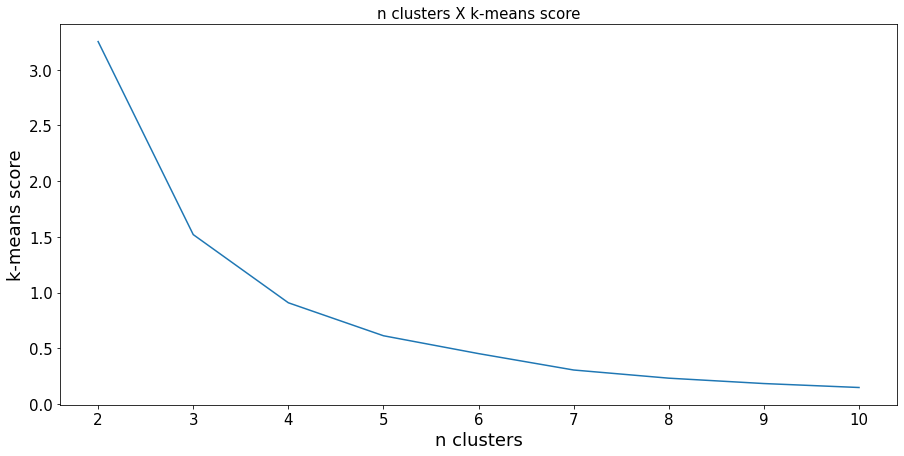

In [21]:
y = []
for k in k_values:
    distancia = clusters[str(k)]['distancia'][0]
    y.append(distancia)
    
plt.figure(figsize=(15, 7))
plt.plot(k_values, y)
plt.title('n clusters X k-means score')
plt.xlabel('n clusters')
plt.ylabel('k-means score')
plt.show()

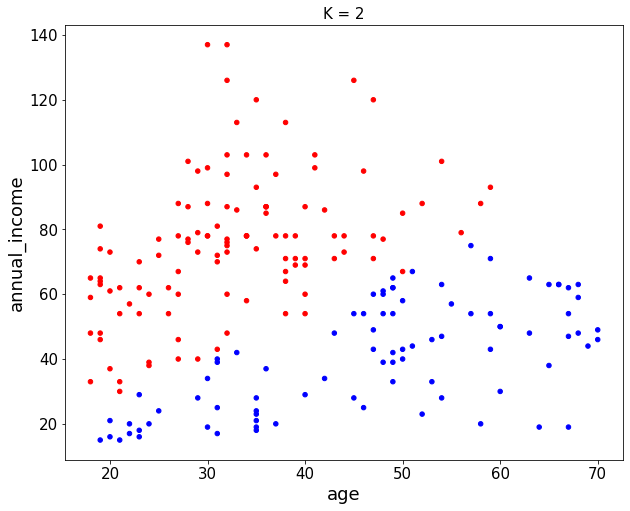

In [22]:
# Com k = 2
k = 2
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df_aux.plot(x='age', y='annual_income', kind='scatter', color=df['color'],
        figsize=(10,8), title='K = 2')
plt.show()

In [23]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 86 elementos.
O cluster 1 - red possui 114 elementos.


For n_clusters = 2 The average silhouette_score is : 0.642036722568442


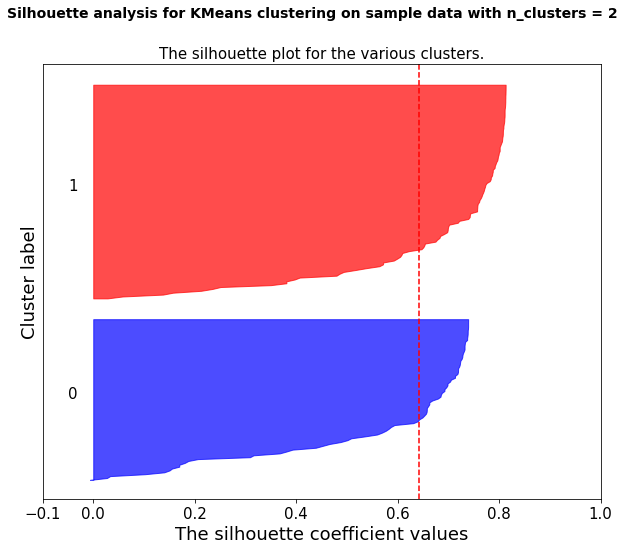

In [24]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 3'}, xlabel='age', ylabel='annual_income'>

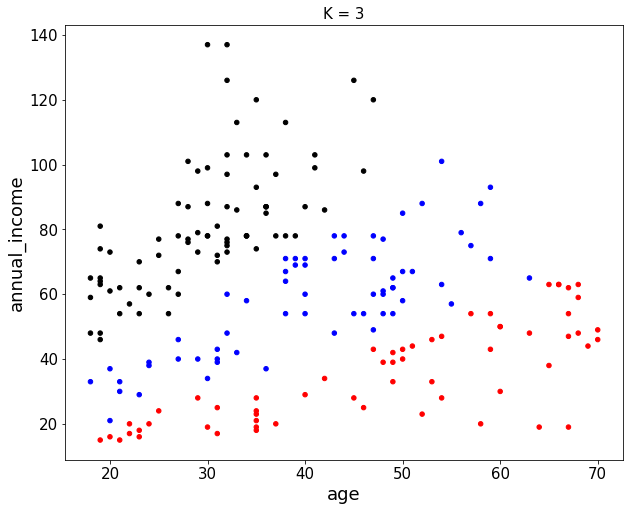

In [25]:
# Com k = 3
k = 3
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='age', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 3')

In [26]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 63 elementos.
O cluster 1 - red possui 60 elementos.
O cluster 2 - black possui 77 elementos.


For n_clusters = 3 The average silhouette_score is : 0.6171912531942989


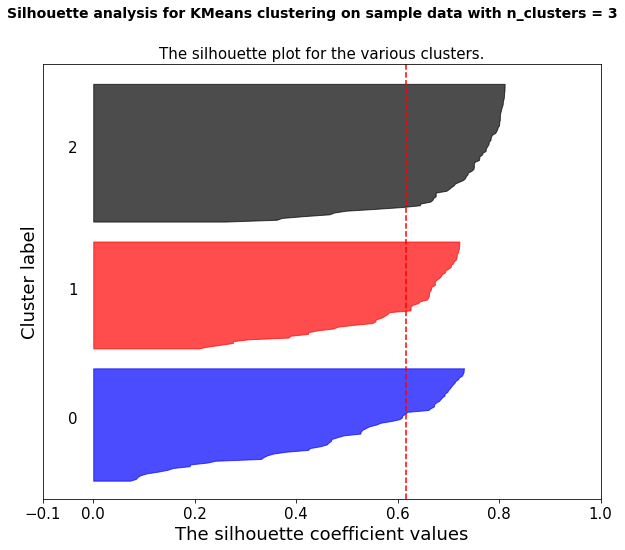

In [27]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 4'}, xlabel='age', ylabel='annual_income'>

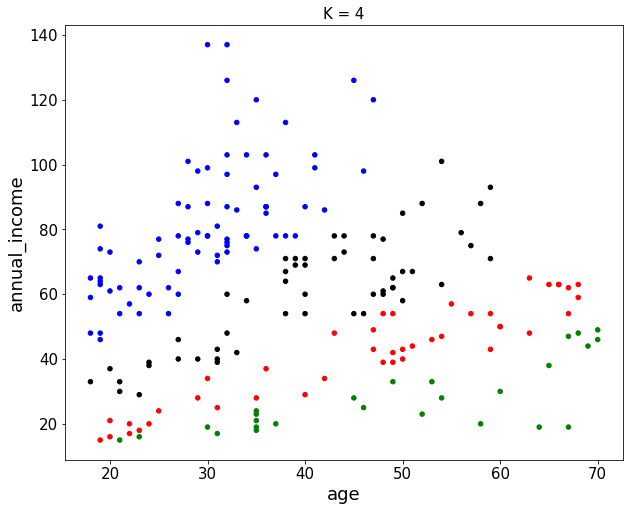

In [28]:
# Com k = 4
k = 4
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='age', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 4')

In [29]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 77 elementos.
O cluster 1 - red possui 43 elementos.
O cluster 2 - black possui 54 elementos.
O cluster 3 - green possui 26 elementos.


For n_clusters = 4 The average silhouette_score is : 0.5954016202439549


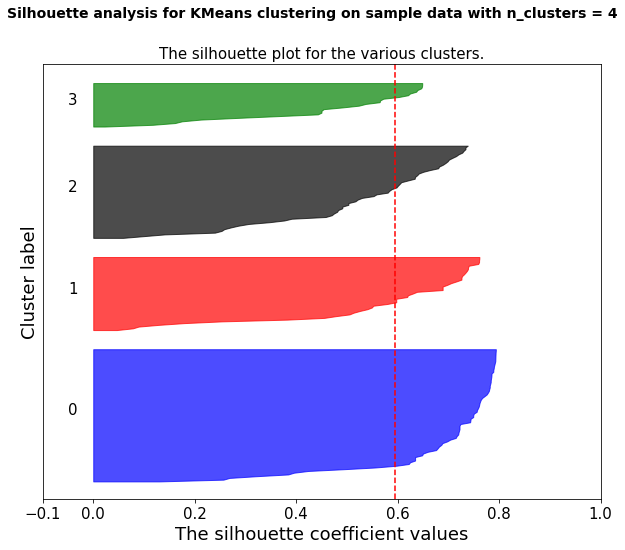

In [30]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 5'}, xlabel='age', ylabel='annual_income'>

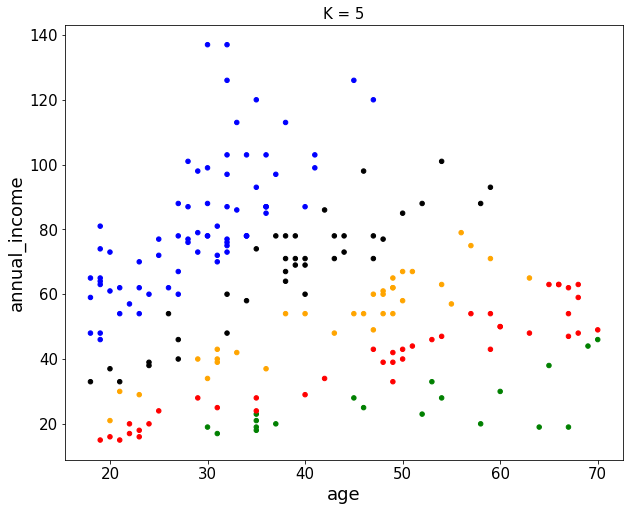

In [31]:
# Com k = 5
k = 5
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='age', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 5')

In [32]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 70 elementos.
O cluster 1 - red possui 41 elementos.
O cluster 2 - black possui 37 elementos.
O cluster 3 - green possui 19 elementos.
O cluster 4 - orange possui 33 elementos.


For n_clusters = 5 The average silhouette_score is : 0.5802233426162539


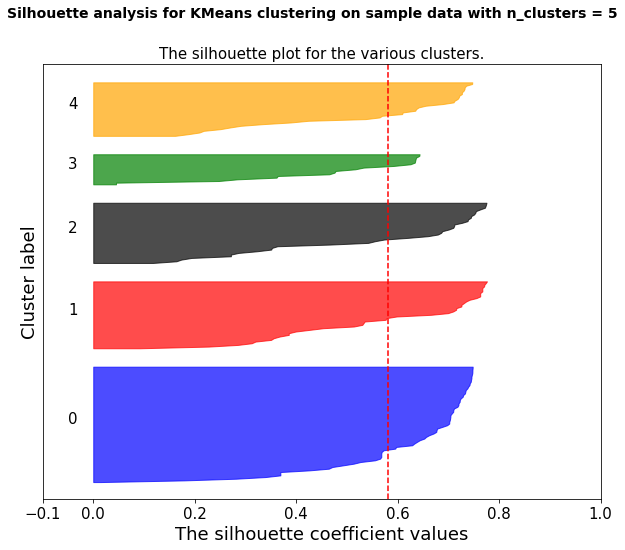

In [33]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 6'}, xlabel='age', ylabel='annual_income'>

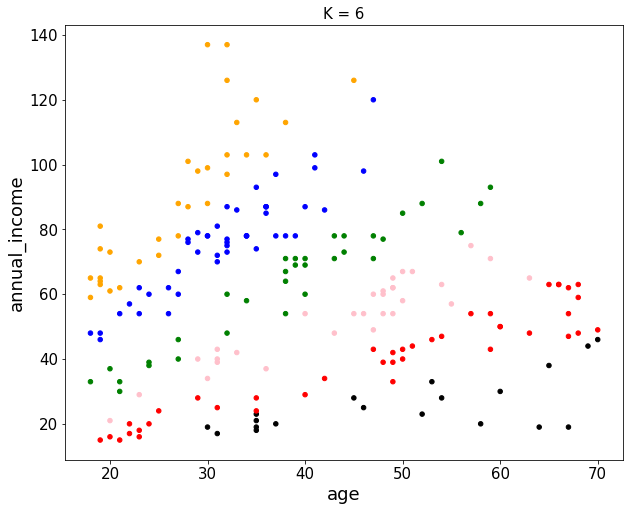

In [34]:
# Com k = 6
k = 6
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='age', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 6')

In [35]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 46 elementos.
O cluster 1 - red possui 41 elementos.
O cluster 2 - black possui 19 elementos.
O cluster 3 - green possui 33 elementos.
O cluster 4 - orange possui 31 elementos.
O cluster 5 - pink possui 30 elementos.


For n_clusters = 6 The average silhouette_score is : 0.5668933381493629


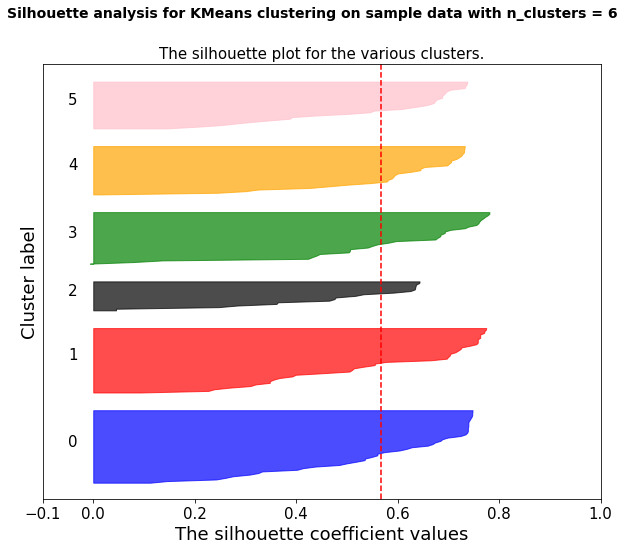

In [36]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 7'}, xlabel='age', ylabel='annual_income'>

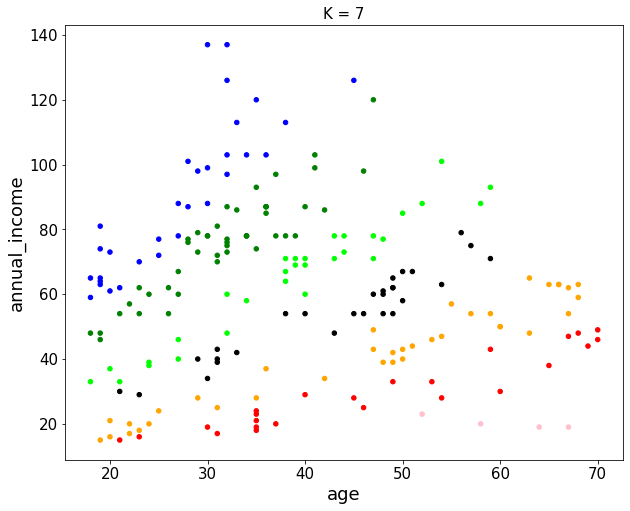

In [37]:
# Com k = 7
k = 7
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='age', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 7')

In [38]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 31 elementos.
O cluster 1 - red possui 24 elementos.
O cluster 2 - black possui 28 elementos.
O cluster 3 - green possui 46 elementos.
O cluster 4 - orange possui 37 elementos.
O cluster 5 - pink possui 4 elementos.
O cluster 6 - lime possui 30 elementos.


For n_clusters = 7 The average silhouette_score is : 0.5813512130557617


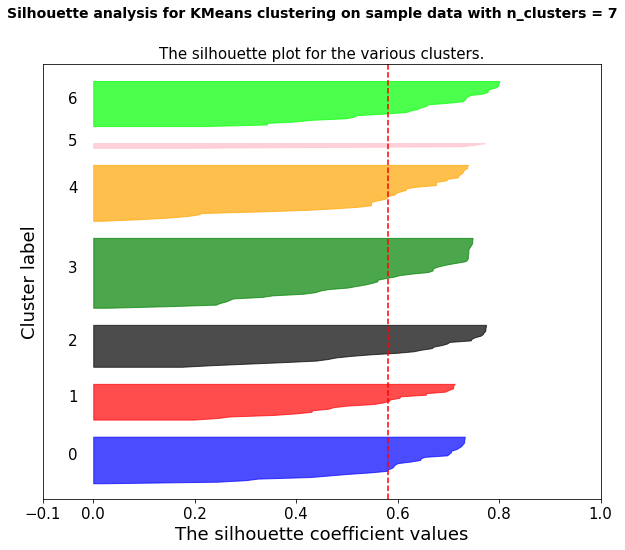

In [39]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

### Verificando se há uma relação entre idade e score

In [40]:
df_aux = df[['age', 'score']]
X = Normalizer().fit_transform(df_aux.values)

In [41]:
k_values = range(2, 11)
clusters = {}

for k in k_values:
    dados = {'k_elementos':[], 'labels': np.ndarray, 'silhueta': [], 'distancia':[]}
    
    kmeans = KMeans(n_clusters=k).fit(X)
    lables = list(kmeans.labels_)
    s = silhouette_score(X, kmeans.labels_, metric='euclidean')
    d = kmeans.inertia_
    
    dados['labels'] = kmeans.labels_
    dados['k_elementos'] = m.quantidade_elementos_cluster(lables, k)
    dados['silhueta'].append(s)
    dados['distancia'].append(d)
    
    clusters[str(k)] = dados

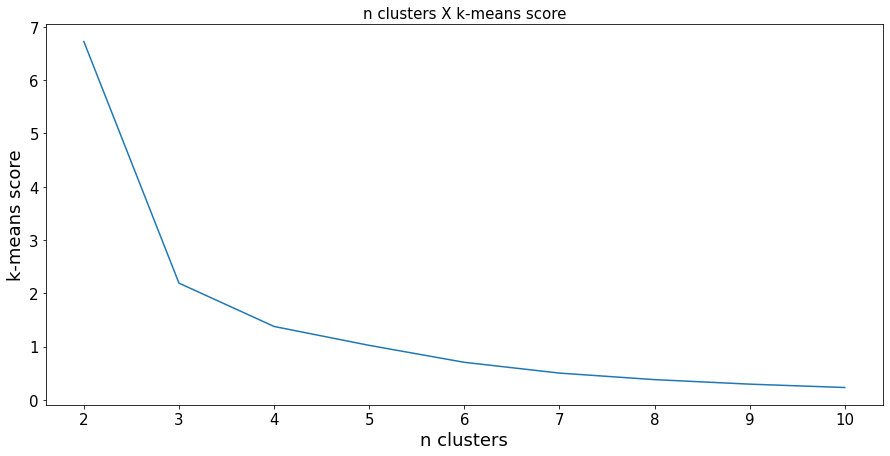

In [42]:
y = []
for k in k_values:
    distancia = clusters[str(k)]['distancia'][0]
    y.append(distancia)
    
plt.figure(figsize=(15, 7))
plt.plot(k_values, y)
plt.title('n clusters X k-means score')
plt.xlabel('n clusters')
plt.ylabel('k-means score')
plt.show()

<AxesSubplot:title={'center':'K = 2'}, xlabel='age', ylabel='score'>

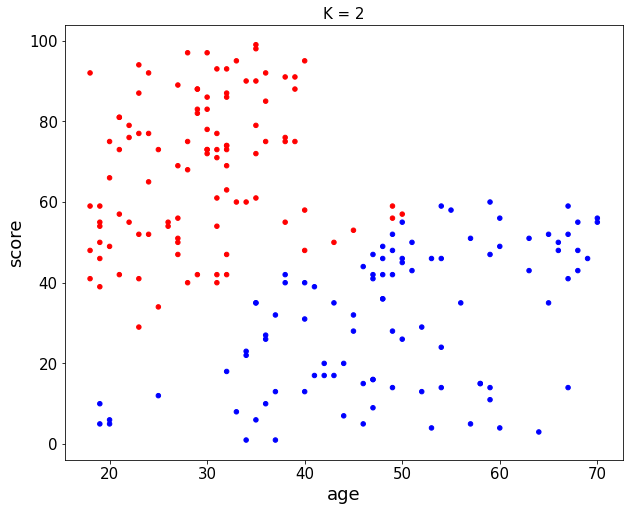

In [43]:
# Com k = 2
k = 2
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='age', y='score', kind='scatter', color=df['color'], figsize=(10,8), title='K = 2')

In [44]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 97 elementos.
O cluster 1 - red possui 103 elementos.


For n_clusters = 2 The average silhouette_score is : 0.6420852019180694


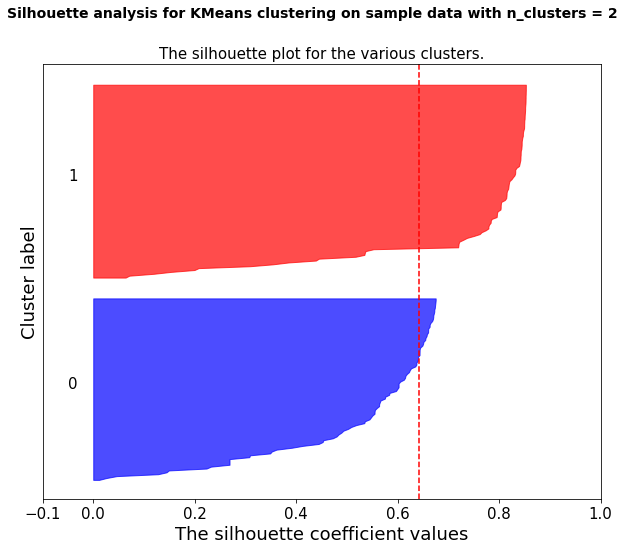

In [45]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 3'}, xlabel='age', ylabel='score'>

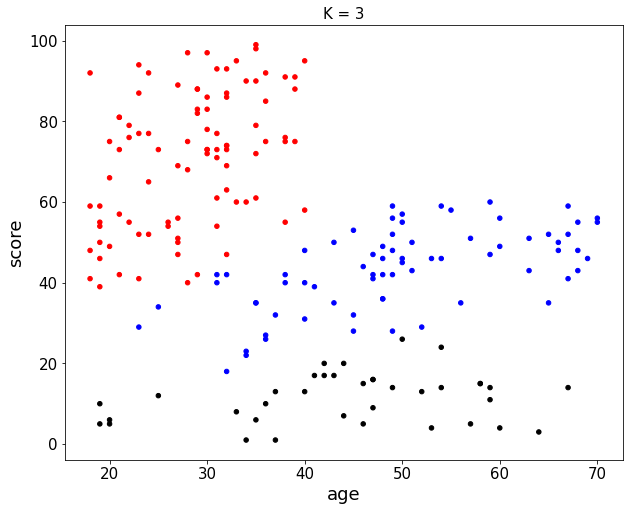

In [46]:
# Com k = 3
k = 3
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='age', y='score', kind='scatter', color=df['color'], figsize=(10,8), title='K = 3')

In [47]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 71 elementos.
O cluster 1 - red possui 92 elementos.
O cluster 2 - black possui 37 elementos.


For n_clusters = 3 The average silhouette_score is : 0.6854473086052212


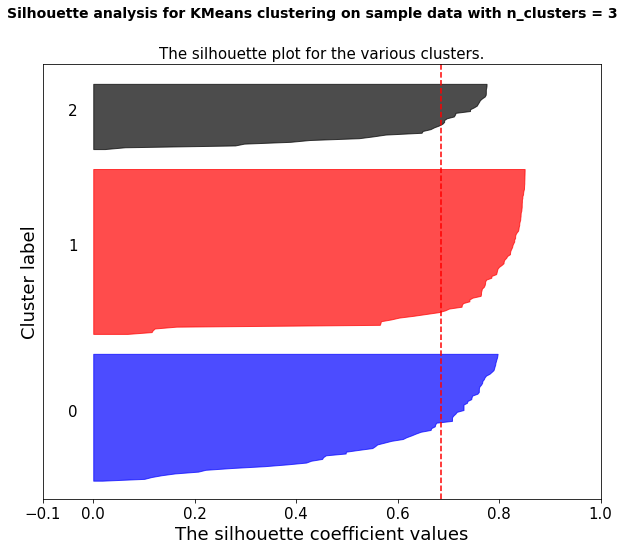

In [48]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 4'}, xlabel='age', ylabel='score'>

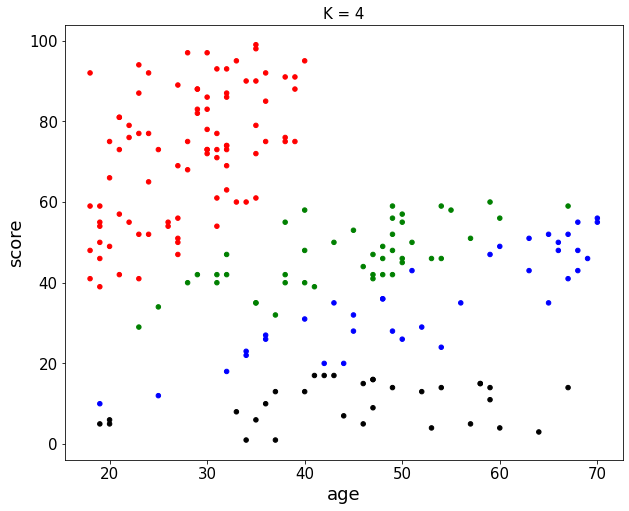

In [49]:
# Com k = 4
k = 4
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='age', y='score', kind='scatter', color=df['color'], figsize=(10,8), title='K = 4')

In [50]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 37 elementos.
O cluster 1 - red possui 87 elementos.
O cluster 2 - black possui 31 elementos.
O cluster 3 - green possui 45 elementos.


For n_clusters = 4 The average silhouette_score is : 0.6314456449901086


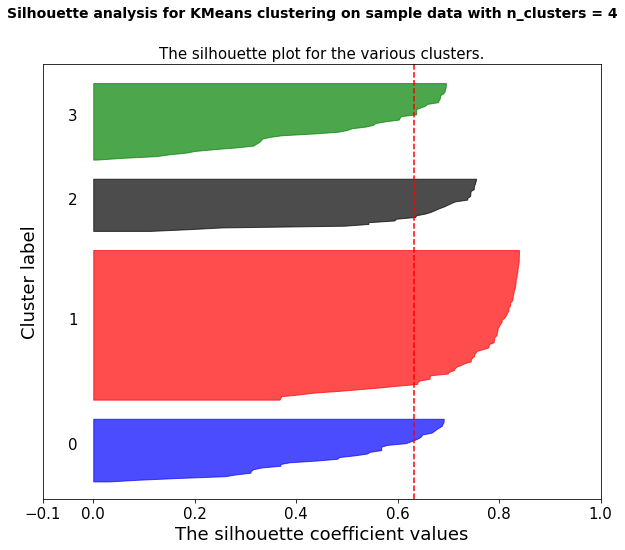

In [51]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 5'}, xlabel='age', ylabel='score'>

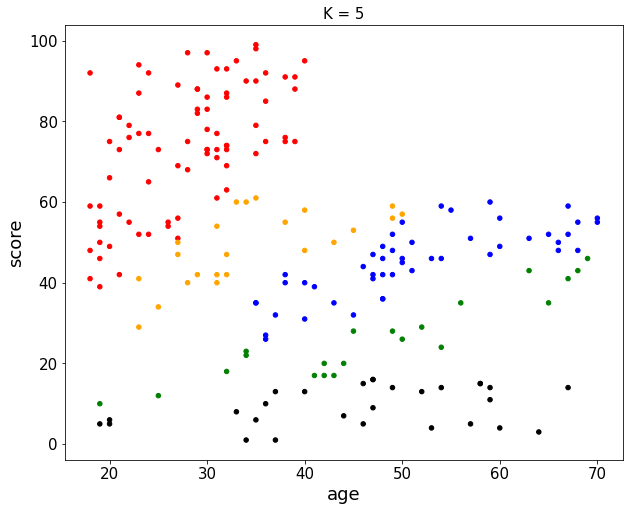

In [52]:
# Com k = 5
k = 5
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='age', y='score', kind='scatter', color=df['color'], figsize=(10,8), title='K = 5')

In [53]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 48 elementos.
O cluster 1 - red possui 80 elementos.
O cluster 2 - black possui 28 elementos.
O cluster 3 - green possui 21 elementos.
O cluster 4 - orange possui 23 elementos.


For n_clusters = 5 The average silhouette_score is : 0.5852681726791985


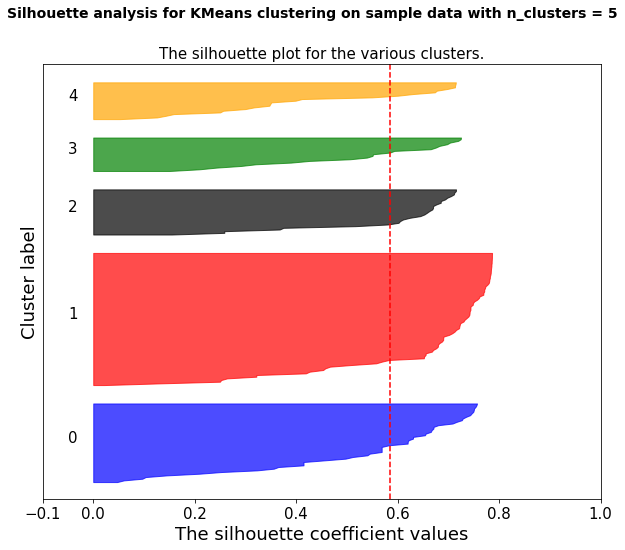

In [54]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 6'}, xlabel='age', ylabel='score'>

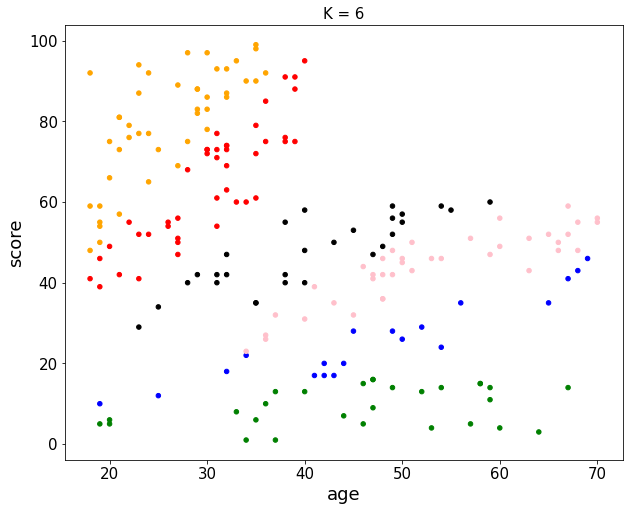

In [55]:
# Com k = 6
k = 6
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='age', y='score', kind='scatter', color=df['color'], figsize=(10,8), title='K = 6')

In [56]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 19 elementos.
O cluster 1 - red possui 43 elementos.
O cluster 2 - black possui 28 elementos.
O cluster 3 - green possui 28 elementos.
O cluster 4 - orange possui 44 elementos.
O cluster 5 - pink possui 38 elementos.


For n_clusters = 6 The average silhouette_score is : 0.5453330362413173


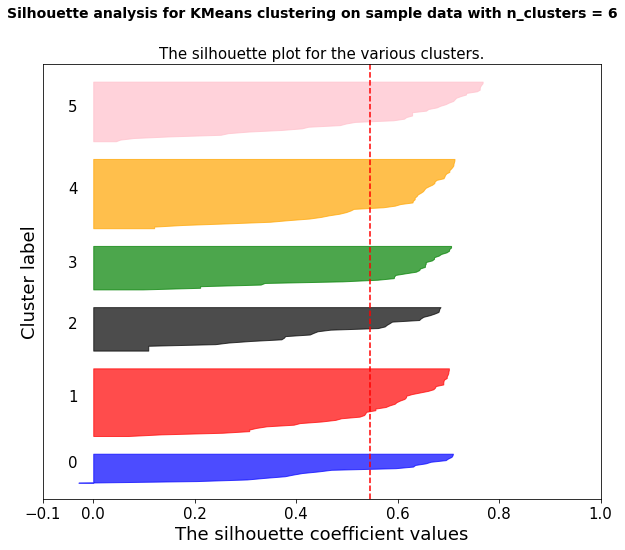

In [57]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 7'}, xlabel='age', ylabel='score'>

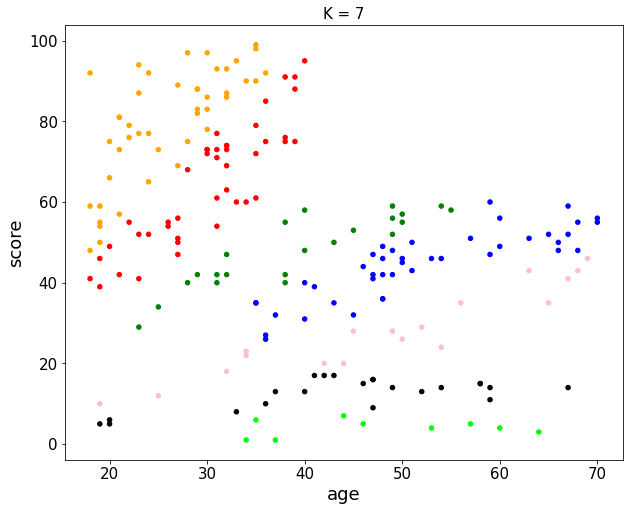

In [58]:
# Com k = 7
k = 7
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='age', y='score', kind='scatter', color=df['color'], figsize=(10,8), title='K = 7')

In [59]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 42 elementos.
O cluster 1 - red possui 43 elementos.
O cluster 2 - black possui 22 elementos.
O cluster 3 - green possui 22 elementos.
O cluster 4 - orange possui 44 elementos.
O cluster 5 - pink possui 18 elementos.
O cluster 6 - lime possui 9 elementos.


For n_clusters = 7 The average silhouette_score is : 0.5456504964562406


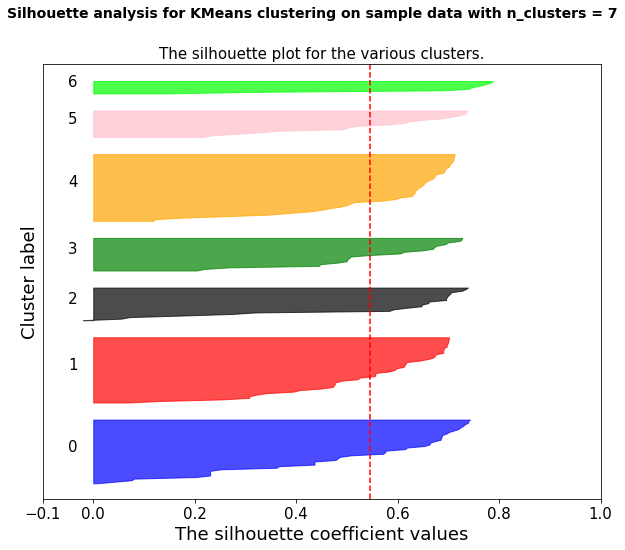

In [60]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

### Verificando se há uma relação entre redimento anual e score

In [61]:
df_aux = df[['annual_income', 'score']]
X = Normalizer().fit_transform(df_aux.values)

In [62]:
k_values = range(2, 11)
clusters = {}

for k in k_values:
    dados = {'k_elementos':[], 'labels': np.ndarray, 'silhueta': [], 'distancia':[]}
    
    kmeans = KMeans(n_clusters=k).fit(X)
    lables = list(kmeans.labels_)
    s = silhouette_score(X, kmeans.labels_, metric='euclidean')
    d = kmeans.inertia_
    
    dados['labels'] = kmeans.labels_
    dados['k_elementos'] = m.quantidade_elementos_cluster(lables, k)
    dados['silhueta'].append(s)
    dados['distancia'].append(d)
    
    clusters[str(k)] = dados

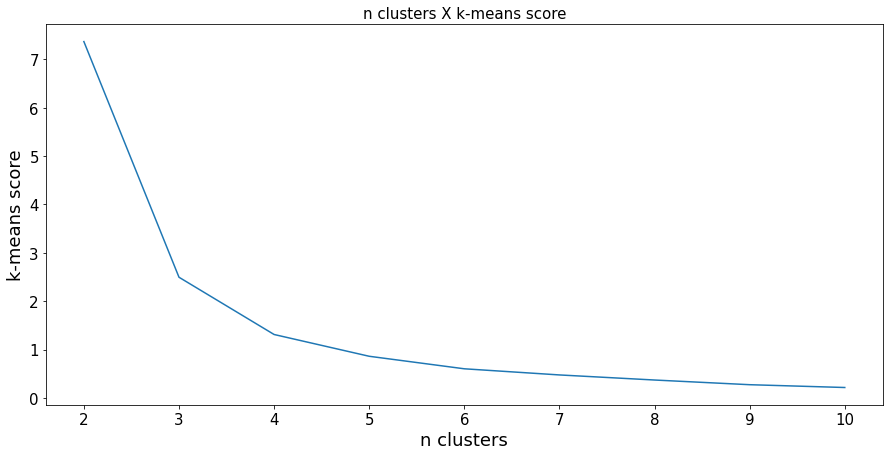

In [63]:
y = []
for k in k_values:
    distancia = clusters[str(k)]['distancia'][0]
    y.append(distancia)
    
plt.figure(figsize=(15, 7))
plt.plot(k_values, y)
plt.title('n clusters X k-means score')
plt.xlabel('n clusters')
plt.ylabel('k-means score')
plt.show()

<AxesSubplot:title={'center':'K = 2'}, xlabel='score', ylabel='annual_income'>

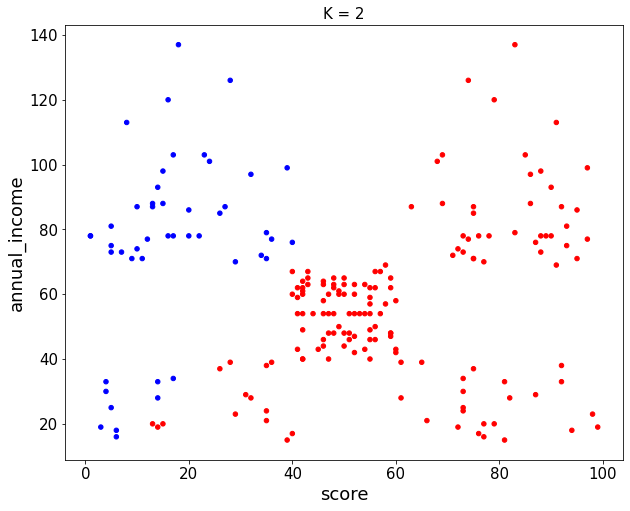

In [64]:
# Com k = 2
k = 2
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='score', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 2')

In [65]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 47 elementos.
O cluster 1 - red possui 153 elementos.


For n_clusters = 2 The average silhouette_score is : 0.636690703289578


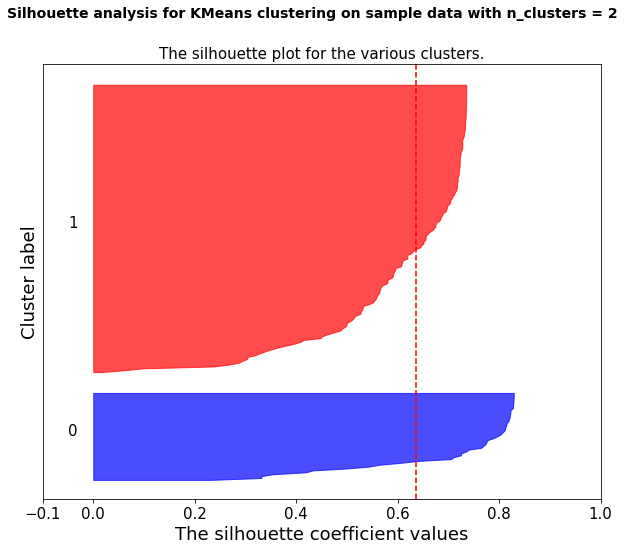

In [66]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 3'}, xlabel='score', ylabel='annual_income'>

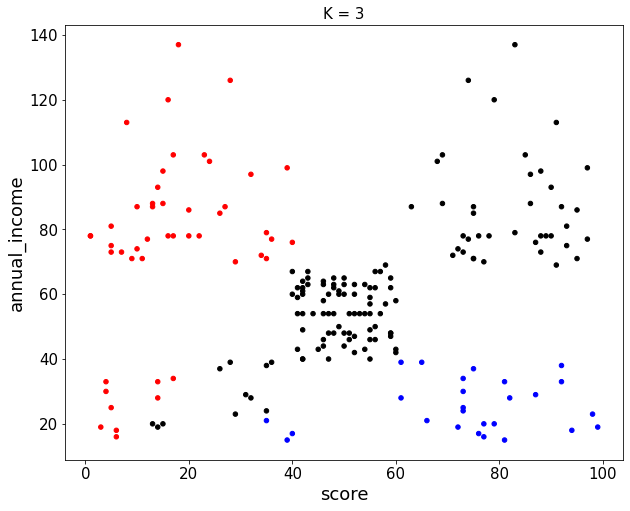

In [67]:
# Com k = 3
k = 3
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='score', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 3')

In [68]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 26 elementos.
O cluster 1 - red possui 47 elementos.
O cluster 2 - black possui 127 elementos.


For n_clusters = 3 The average silhouette_score is : 0.6827537950753007


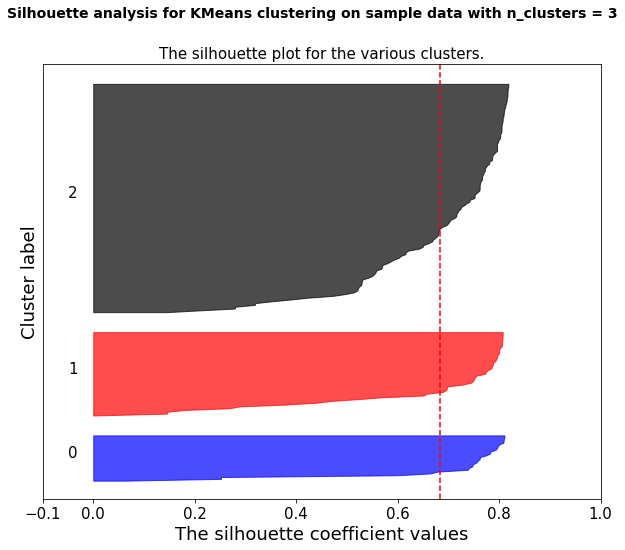

In [69]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 4'}, xlabel='score', ylabel='annual_income'>

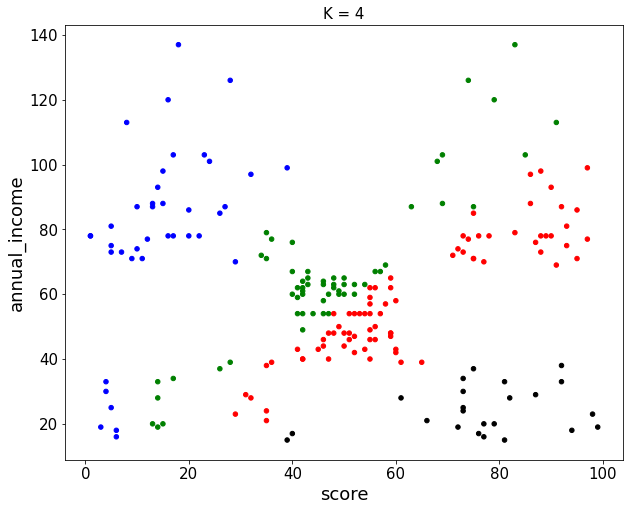

In [70]:
# Com k = 4
k = 4
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='score', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 4')

In [71]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 39 elementos.
O cluster 1 - red possui 80 elementos.
O cluster 2 - black possui 23 elementos.
O cluster 3 - green possui 58 elementos.


For n_clusters = 4 The average silhouette_score is : 0.6056555345020762


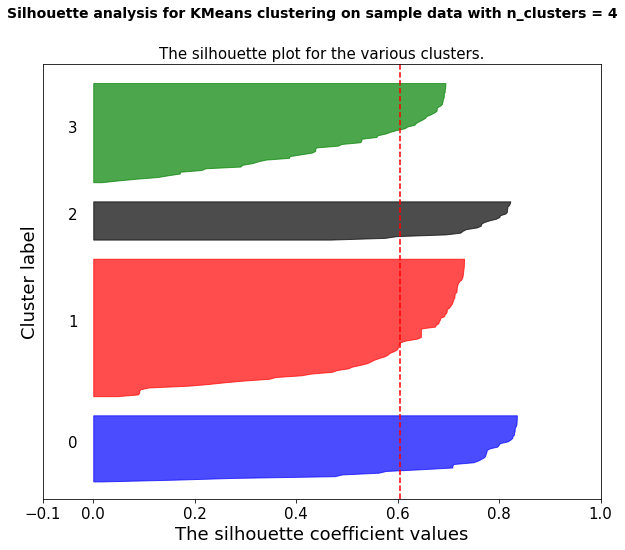

In [72]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 5'}, xlabel='score', ylabel='annual_income'>

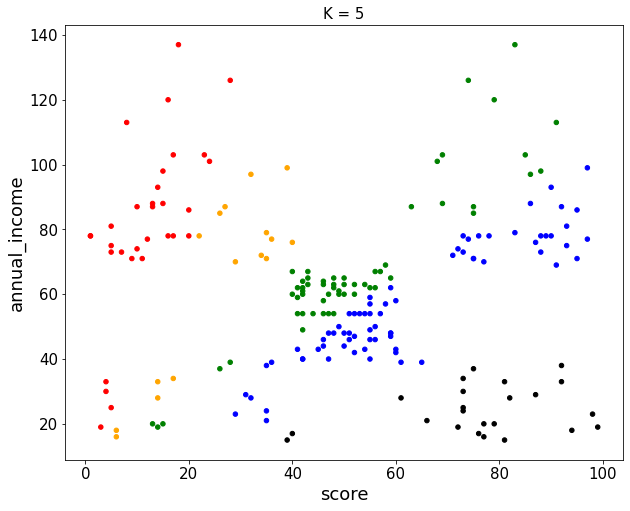

In [73]:
# Com k = 5
k = 5
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='score', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 5')

In [74]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 73 elementos.
O cluster 1 - red possui 31 elementos.
O cluster 2 - black possui 23 elementos.
O cluster 3 - green possui 57 elementos.
O cluster 4 - orange possui 16 elementos.


For n_clusters = 5 The average silhouette_score is : 0.6030183894692748


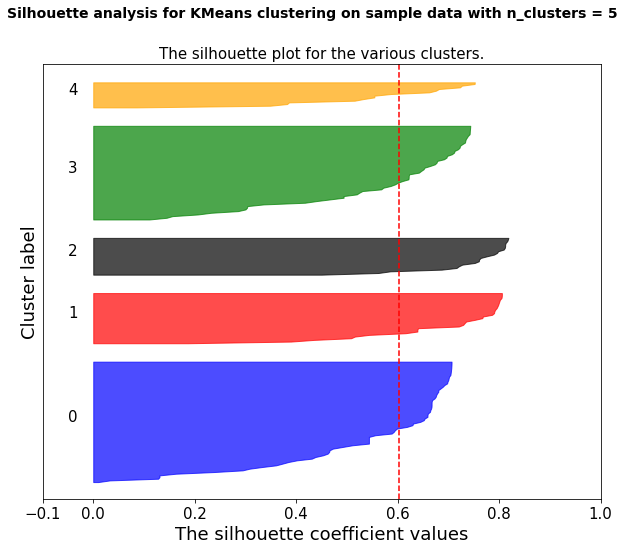

In [75]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 6'}, xlabel='score', ylabel='annual_income'>

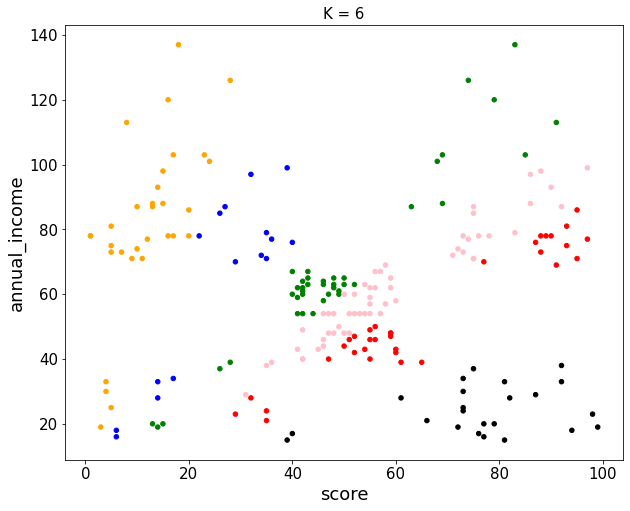

In [76]:
# Com k = 6
k = 6
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='score', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 6')

In [77]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 16 elementos.
O cluster 1 - red possui 34 elementos.
O cluster 2 - black possui 23 elementos.
O cluster 3 - green possui 40 elementos.
O cluster 4 - orange possui 31 elementos.
O cluster 5 - pink possui 56 elementos.


For n_clusters = 6 The average silhouette_score is : 0.5830907685516012


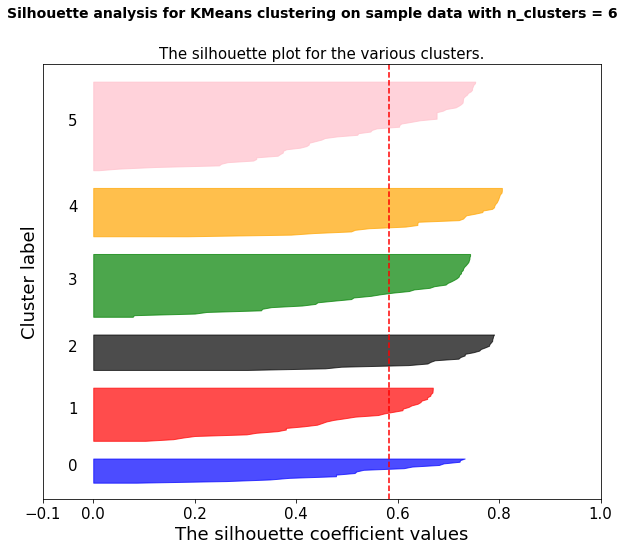

In [78]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:title={'center':'K = 7'}, xlabel='score', ylabel='annual_income'>

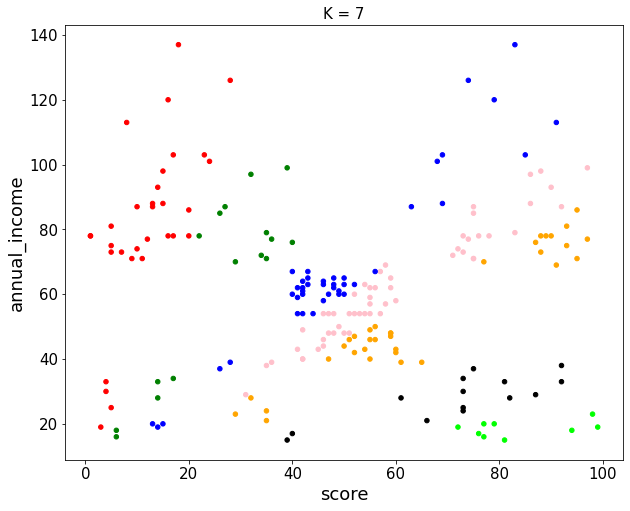

In [79]:
# Com k = 7
k = 7
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='score', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 7')

In [80]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 42 elementos.
O cluster 1 - red possui 31 elementos.
O cluster 2 - black possui 14 elementos.
O cluster 3 - green possui 16 elementos.
O cluster 4 - orange possui 34 elementos.
O cluster 5 - pink possui 54 elementos.
O cluster 6 - lime possui 9 elementos.


For n_clusters = 7 The average silhouette_score is : 0.5752809963471587


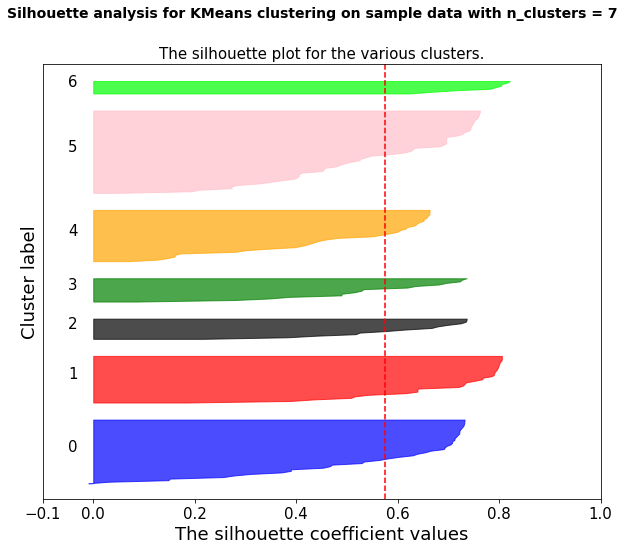

In [81]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:xlabel='score', ylabel='annual_income'>

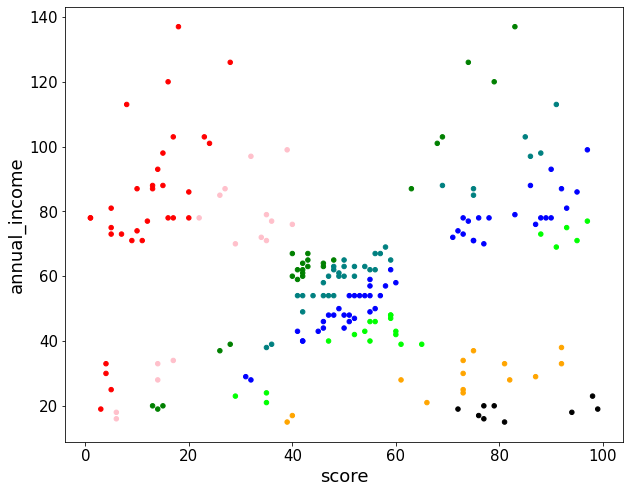

In [82]:
# Com k = 8
k = 8
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='score', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8))

In [83]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 50 elementos.
O cluster 1 - red possui 31 elementos.
O cluster 2 - black possui 9 elementos.
O cluster 3 - green possui 25 elementos.
O cluster 4 - orange possui 14 elementos.
O cluster 5 - pink possui 16 elementos.
O cluster 6 - lime possui 21 elementos.
O cluster 7 - teal possui 34 elementos.


For n_clusters = 8 The average silhouette_score is : 0.5788579793468425


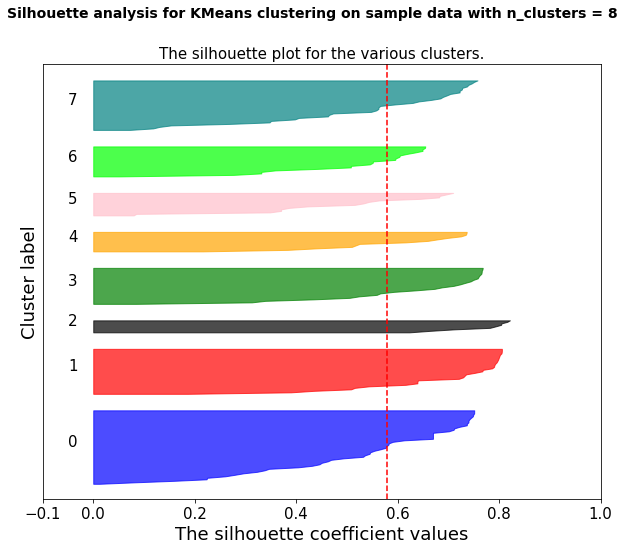

In [84]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

<AxesSubplot:xlabel='score', ylabel='annual_income'>

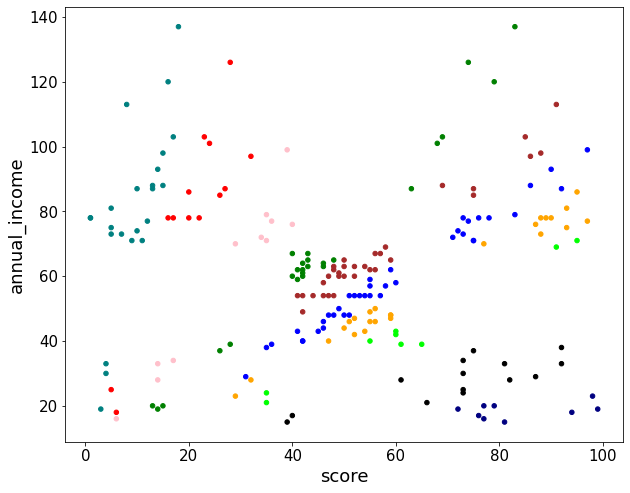

In [85]:
# Com k = 10
k = 10
df_labels = df
df_labels['color'] = clusters[str(k)]['labels']
df_labels['color'] = df_labels.color.map(lambda c: m.get_color(c))
df_labels

df.plot(x='score', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8))

In [86]:
m.mostrar_quantidade_elementos_cluster(k, clusters)

O cluster 0 - blue possui 39 elementos.
O cluster 1 - red possui 13 elementos.
O cluster 2 - black possui 14 elementos.
O cluster 3 - green possui 25 elementos.
O cluster 4 - orange possui 25 elementos.
O cluster 5 - pink possui 11 elementos.
O cluster 6 - lime possui 9 elementos.
O cluster 7 - teal possui 23 elementos.
O cluster 8 - brown possui 32 elementos.
O cluster 9 - navy possui 9 elementos.


For n_clusters = 10 The average silhouette_score is : 0.5824943685082133


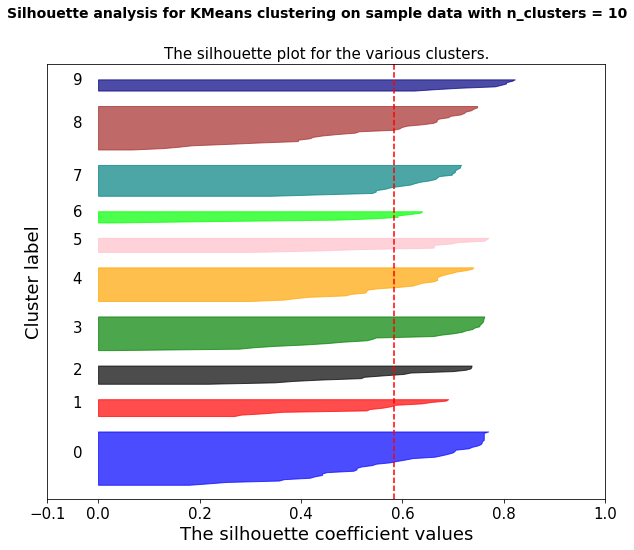

In [87]:
m.plot_silhouette(X, k, clusters[str(k)]['labels'])

## AgglomerativeClustering

In [88]:
from sklearn.cluster import AgglomerativeClustering

In [89]:
df = pd.read_csv('Mall_Customers.csv', sep=',')
df = df.rename(columns={'Age': 'age', 'Annual Income (k$)': 'annual_income', 'Spending Score (1-100)': 'score'})
df = df[['age', 'annual_income']]
df

,age,annual_income
0,19,15
1,21,15
2,20,16
3,23,16
4,31,17
...,...,...
195,35,120
196,45,126
197,32,126
198,32,137


In [90]:
X = Normalizer().fit_transform(df.values)

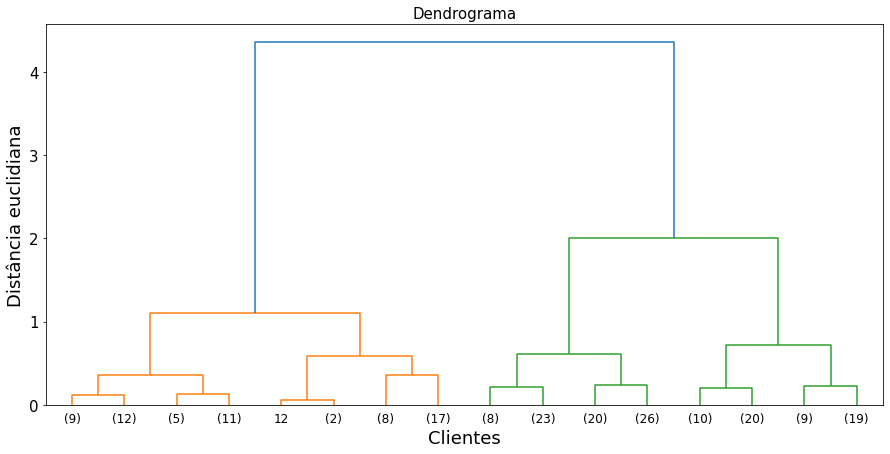

In [91]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model = model.fit(X)
plt.figure(figsize=(15, 7))
plt.xlabel('Clientes')
plt.ylabel('Distância euclidiana')
plt.title('Dendrograma')
m.plot_dendrogram(model,truncate_mode="level", p=3)

In [92]:
# Variando a distância de 1 a 4
distancias = [1, 1.5, 3]
distancias_labels = {}
for distancia in distancias:
    model = AgglomerativeClustering(n_clusters=None, distance_threshold=distancia)
    model = model.fit(X)
    distancias_labels[str(distancia)] = model.labels_    

### Para distância igual a 1, temos 4 grupos

In [93]:
k = 3
distancia = distancias[0]
df['color'] = distancias_labels[str(distancia)]
df

,age,annual_income,color
0,19,15,3
1,21,15,1
2,20,16,3
3,23,16,1
4,31,17,1
...,...,...,...
195,35,120,2
196,45,126,2
197,32,126,2
198,32,137,2


In [94]:
df['color'] = df.color.map(lambda c: m.get_color(c))
df

,age,annual_income,color
0,19,15,green
1,21,15,red
2,20,16,green
3,23,16,red
4,31,17,red
...,...,...,...
195,35,120,black
196,45,126,black
197,32,126,black
198,32,137,black


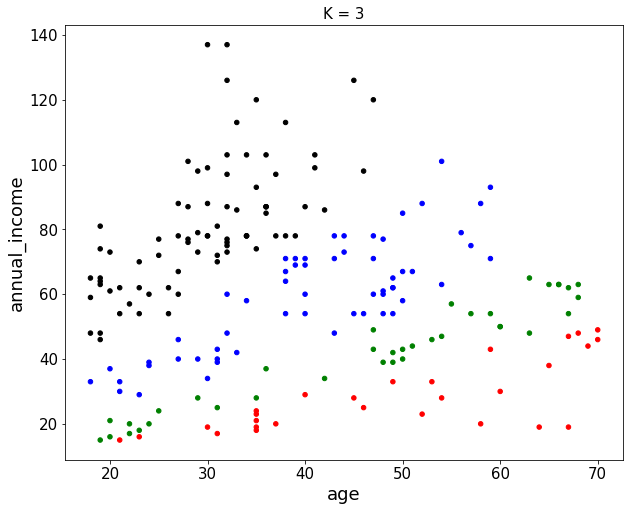

In [95]:
df.plot(x='age', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 3')
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.5934171360066982


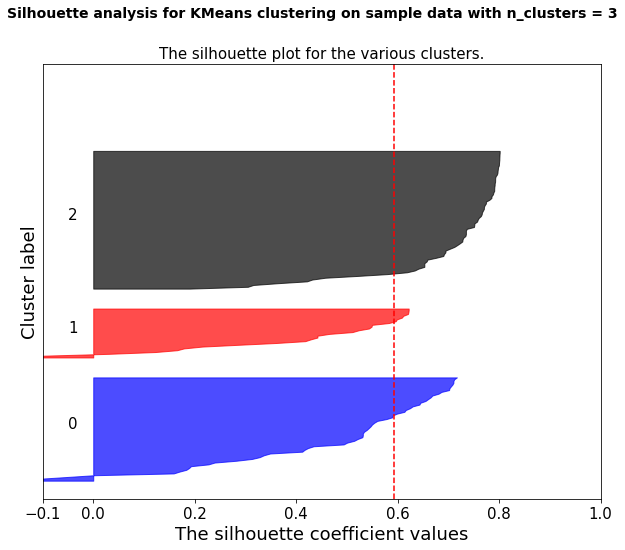

In [96]:
m.plot_silhouette(X, k, distancias_labels[str(distancia)])

### Para distância igual a 1.5, temos 3 grupos

In [97]:
k = 3
distancia = distancias[1]
df['color'] = distancias_labels[str(distancia)]
df

,age,annual_income,color
0,19,15,0
1,21,15,0
2,20,16,0
3,23,16,0
4,31,17,0
...,...,...,...
195,35,120,2
196,45,126,2
197,32,126,2
198,32,137,2


In [98]:
df['color'] = df.color.map(lambda c: m.get_color(c))
df

,age,annual_income,color
0,19,15,blue
1,21,15,blue
2,20,16,blue
3,23,16,blue
4,31,17,blue
...,...,...,...
195,35,120,black
196,45,126,black
197,32,126,black
198,32,137,black


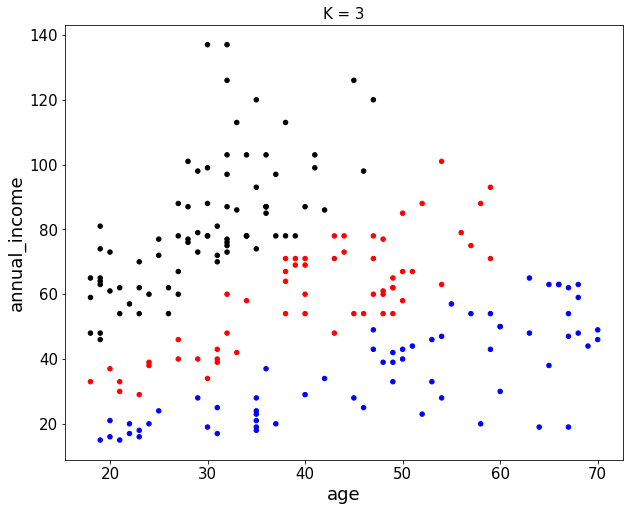

In [99]:
df.plot(x='age', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 3')
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.6184099257331396


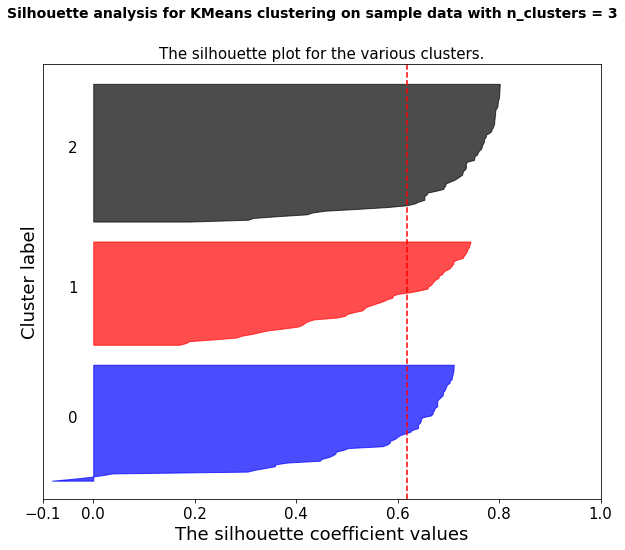

In [100]:
m.plot_silhouette(X, k, distancias_labels[str(distancia)])

### Para distância igual a 3, temos 2 grupos

In [101]:
k = 2
distancia = distancias[2]
df['color'] = distancias_labels[str(distancia)]
df

,age,annual_income,color
0,19,15,1
1,21,15,1
2,20,16,1
3,23,16,1
4,31,17,1
...,...,...,...
195,35,120,0
196,45,126,0
197,32,126,0
198,32,137,0


In [102]:
df['color'] = df.color.map(lambda c: m.get_color(c))
df

,age,annual_income,color
0,19,15,red
1,21,15,red
2,20,16,red
3,23,16,red
4,31,17,red
...,...,...,...
195,35,120,blue
196,45,126,blue
197,32,126,blue
198,32,137,blue


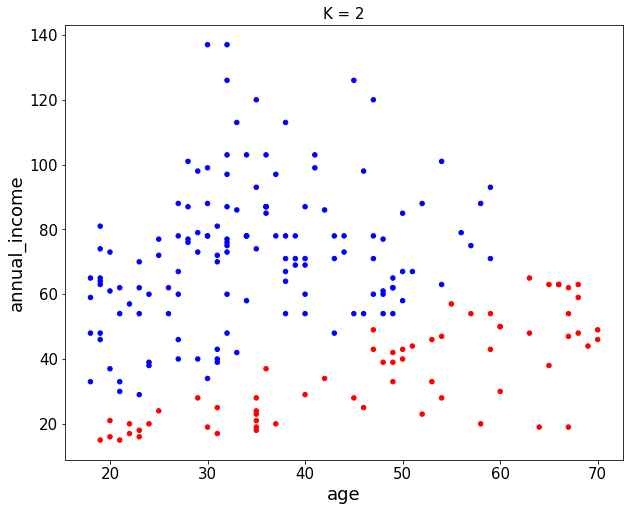

In [103]:
df.plot(x='age', y='annual_income', kind='scatter', color=df['color'], figsize=(10,8), title='K = 2')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6332340091836156


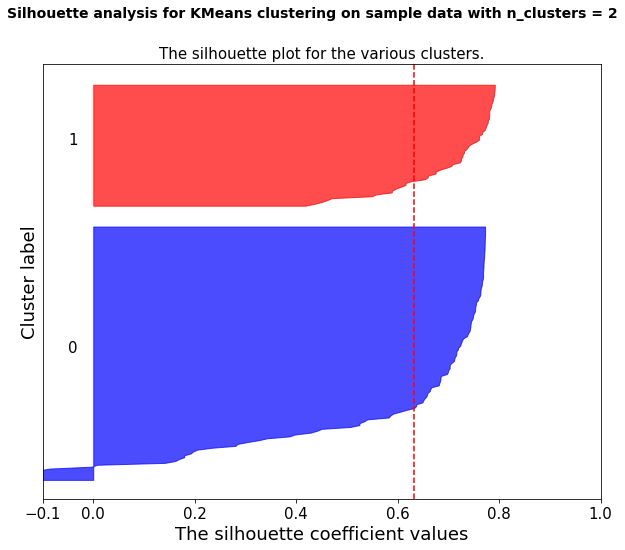

In [104]:
m.plot_silhouette(X, k, distancias_labels[str(distancia)])